### Student Name: Tanaya Jayprakash Bowade
### Student ID: A00014485


---

## Pre-requisites For Running this notebook
1. Download the following data https://drive.google.com/file/d/1YTESoiP7D8kKEw6GaydbBuWOCOCZZyaM/view?usp=drive_link

2. Place the data in the colab virtual space

3. Unzip the file


```
import zipfile

with zipfile.ZipFile('/content/Drug_Response_WebApp.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
```



4. Path of the dataset is

```
/content/Drug_Response_WebApp
```



In [ ]:
import zipfile

with zipfile.ZipFile('/content/Drug_Response_WebApp.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## **Testing Model on Unseen Data**

### Importing and installing necessary libraraies

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.2 MB/s eta 0:00:00


In [ ]:
import torch


from torch_geometric.data import InMemoryDataset
from torch_geometric.data import DataLoader
from torch_geometric import data as DATA


import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_add_pool

import math
from math import sqrt
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import os

In [ ]:
# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Loading the test data

In [ ]:
class DrugGeneDataset(InMemoryDataset):
    """
    Custom PyTorch dataset for loading and processing drug and gene expression data.
    """
    def __init__(self, root='root_folder', dataset_name='gdsc',
                 drug_smiles=None, cell_profiles=None, response_values=None, transform=None,
                 pre_transform=None, smiles_graph_map=None, saliency_map=False, test_mode=False, drug_ids=None, cell_ids=None):
        """
        Initialize the dataset by reading raw and processed files for a given dataset.

        Args:
            root (str): Base directory where dataset files are stored.
            dataset_name (str): The specific dataset name to load.
        """
        super(DrugGeneDataset, self).__init__(root, transform, pre_transform)

        self.dataset_name = dataset_name
        self.saliency_map = saliency_map
        self.test_mode = test_mode

        if (self.test_mode):
            self.process(drug_smiles, cell_profiles, response_values, smiles_graph_map, drug_ids, cell_ids)
        elif os.path.isfile(self.processed_paths[0]):
            print(f"Pre-processed data found at: {self.processed_paths[0]} — loading...")

            self.data, self.slices = torch.load(self.processed_paths[0],weights_only=False)
        else:
            print(f"Pre-processed data not found at {self.processed_paths[0]}. Starting pre-processing...")
            self.process(drug_smiles, cell_profiles, response_values, smiles_graph_map, drug_ids, cell_ids)
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        pass

    @property
    def processed_file_names(self):
        return [self.dataset_name + '.pt']

    def download(self):
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)


    def process(self, drug_smiles, cell_profiles, response_values, smiles_graph_map, drug_ids, cell_ids):

        assert (len(drug_smiles) == len(cell_profiles) and len(cell_profiles) == len(
            response_values)), "Input lengths must match!"
        data_instances = []
        total_samples = len(drug_smiles)

        for idx in range(total_samples):

            if ((idx % 2000 == 0 or idx+1 == total_samples) and (not self.test_mode)):
                print('Preprocessing: SMILES to graph: {}/{}'.format(idx+1, total_samples))

            current_smile = drug_smiles[idx]
            cell_expression = cell_profiles[idx]
            ic50_val = response_values[idx]

            drug_label = drug_ids[idx]
            cell_label = cell_ids[idx]

            num_nodes, node_features, edge_indices, bond_features, nx_g = smiles_graph_map[current_smile]

            if (self.test_mode):
                ptr_tensor = torch.tensor([0, int(num_nodes)])
                batch_tensor = torch.zeros((int(num_nodes)), dtype=int)
                data_item = DATA.Data(x=torch.Tensor(node_features),
                                    edge_index=torch.LongTensor(
                                        edge_indices).transpose(1, 0),
                                    y=torch.FloatTensor([ic50_val]), batch=batch_tensor, ptr=ptr_tensor, smiles=current_smile, drug_name=drug_label, cell_line_name=cell_label)
            else:
                data_item = DATA.Data(x=torch.Tensor(node_features),
                                    edge_index=torch.LongTensor(
                                        edge_indices).transpose(1, 0),
                                    edge_features=torch.Tensor(
                                        bond_features),
                                    y=torch.FloatTensor([ic50_val]), smiles=current_smile, drug_name=drug_label, cell_line_name=cell_label)


            if self.saliency_map == True:
                data_item.target = torch.tensor(
                    [cell_expression], dtype=torch.float, requires_grad=True)
            else:
                data_item.target = torch.FloatTensor([cell_expression])

            data_item.__setitem__('num_nodes', torch.LongTensor([num_nodes]))

            data_instances.append(data_item)

        if (self.test_mode):
            ptr_tensor = torch.tensor([0, int(num_nodes)])
            batch_tensor = torch.zeros((int(num_nodes)), dtype=int)

        if self.pre_transform is not None:
            data_instances = [self.pre_transform(d) for d in data_instances]

        if (self.test_mode):
            return data_instances

        print('Saving graph dataset to disk...')
        data, slices = self.collate(data_instances)

        if (self.test_mode):
            return (data, slices)

        print(" Saved to file.")
        # save preprocessed data:
        torch.save((data, slices), self.processed_paths[0])
        print(" Complete.")

    def get_drug_smiles(self):
        return self.drug_smiles

In [ ]:
def load_datasets(br_fol, dataset):
    '''
    Helper function for loading the datasets.
    '''
    return {
        "test": DrugGeneDataset(root=br_fol, dataset_name=f"{dataset}_test_set")
    }

def get_data_loaders(datasets, batch_sizes):
    '''
    Helper function for fetching the DataLoader.
    '''
    return {
        "test": DataLoader(datasets["test"], batch_size=batch_sizes["test"], shuffle=False)
    }


In [ ]:
br_fol='/content/Drug_Response_WebApp'

datasets = load_datasets(br_fol, dataset="Data")

batch_sizes = {"test": 32}
data_loaders = get_data_loaders(datasets, batch_sizes)

test_loader = data_loaders["test"]

test_dataset=datasets["test"]

d_feat_size = test_dataset[0].x.shape[1]
print(f"Detected input feature size: {d_feat_size}")

Pre-processed data found at: /content/Drug_Response_WebApp/processed/Data_test_set.pt — loading...
Detected input feature size: 78


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Loading the saved model from the Training Phase

In [ ]:
# The Model Class

class DrugResponseModel(torch.nn.Module):
    def __init__(self, output_size=1, conv_filters=32, embedding_dim=128, drug_feat_dim=334, output_dim=128, dropout_rate=0.5):  # qwe

        super(DrugResponseModel, self).__init__()

        self.output_size = output_size

        # Graph Convolutional Network layers for drug SMILES representation
        self.gcn_layer1 = GCNConv(drug_feat_dim, drug_feat_dim)
        self.gcn_layer2 = GCNConv(drug_feat_dim, drug_feat_dim*2)
        self.gcn_layer3 = GCNConv(drug_feat_dim*2, drug_feat_dim * 4)

        self.fc_gcn1 = torch.nn.Linear(drug_feat_dim*4, 1024)
        self.fc_gcn2 = torch.nn.Linear(1024, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        # 1D CNN layers for cell line feature extraction
        self.cell_conv1 = nn.Conv1d(
            in_channels=1, out_channels=conv_filters, kernel_size=8)
        self.cell_pool1 = nn.MaxPool1d(3)

        self.cell_conv2 = nn.Conv1d(
            in_channels=conv_filters, out_channels=conv_filters*2, kernel_size=8)
        self.cell_pool2 = nn.MaxPool1d(3)

        self.cell_conv3 = nn.Conv1d(
            in_channels=conv_filters*2, out_channels=conv_filters*4, kernel_size=8)
        self.cell_pool3 = nn.MaxPool1d(3)

        self.fc_cell = nn.Linear(4096, output_dim)

        # Cross-attention layers to fuse drug and cell features
        self.cross_attention1 = nn.MultiheadAttention(output_dim, num_heads=8, dropout=dropout_rate)
        self.cross_attention2 = nn.MultiheadAttention(output_dim, num_heads=8, dropout=dropout_rate)

        self.norm_attn1 = nn.LayerNorm(output_dim)
        self.norm_attn2 = nn.LayerNorm(output_dim)

        # Fully connected layers for final prediction
        self.fc_combined = nn.Linear(2*output_dim, 128)
        self.output_layer = nn.Linear(128, self.output_size)

    def forward(self, x, edge_idx, batch, cell_x, edge_weight=None):

        # GCN branch for drug input
        x = self.gcn_layer1(x, edge_idx, edge_weight)
        x = self.relu(x)

        x = self.gcn_layer2(x, edge_idx, edge_weight)
        x = self.relu(x)

        x = self.gcn_layer3(x, edge_idx, edge_weight)
        x = self.relu(x)

        # Global Max Pooling across graph nodes
        x = gmp(x, batch)

        # Fully connected layers for drug features
        x = self.relu(self.fc_gcn1(x))
        x = self.dropout(x)
        x = self.fc_gcn2(x)
        x = self.dropout(x)


        # 1D CNN branch for cell line features
        cell_feat = self.cell_conv1(cell_x)
        cell_feat = F.relu(cell_feat)
        cell_feat = self.cell_pool1(cell_feat)

        cell_feat = self.cell_conv2(cell_feat)
        cell_feat = F.relu(cell_feat)
        cell_feat = self.cell_pool2(cell_feat)

        cell_feat = self.cell_conv3(cell_feat)
        cell_feat = F.relu(cell_feat)
        cell_feat = self.cell_pool3(cell_feat)

        # Flatten and apply fully connected layer
        xt = cell_feat.view(-1, cell_feat.shape[1] * cell_feat.shape[2])
        xt = self.fc_cell(xt)

        print(f"x shape: {x.shape}")
        print(f"xt shape: {xt.shape}")


        # Cross-attention mechanism
        attn_out1, _ = self.cross_attention1(x, xt, xt)
        attn_out1 = attn_out1 + x
        attn_out1 = self.norm_attn1(attn_out1)

        attn_out2, _ = self.cross_attention2(xt, x, x)
        attn_out2 = attn_out2 + xt
        attn_out2 = self.norm_attn2(attn_out2)

        # Concatenate and classify
        combined = torch.cat((attn_out1, attn_out2), 1)
        combined = self.relu(combined)
        combined = self.dropout(combined)

        combined = self.fc_combined(combined)
        combined = self.relu(combined)
        combined = self.dropout(combined)

        output = self.output_layer(combined)
        output = nn.Sigmoid()(output)

        return output


In [ ]:
# Loading the saved model in the training phase

model2_path = '/content/Drug_Response_WebApp/baseline.model'
model2 = DrugResponseModel(drug_feat_dim=d_feat_size).to(device)
model2.load_state_dict(torch.load(model2_path, map_location=device))
#model.eval()

<All keys matched successfully>

### Defining the prediction and evaluation functions

In [ ]:
def predicting_and_evaluate(model, device, data_loader):
    """
    Performs prediction on a dataset and computes evaluation metrics.

    Args:
        model: Trained model.
        device: 'cuda' or 'cpu'.
        data_loader: DataLoader for validation or test.

    Returns:
        Dictionary containing rmse, mse, pearson, spearman and r2 scores.
    """
    predictions, ground_truth = predict(model, device, data_loader)
    return {
        "rmse": compute_rmse(ground_truth, predictions),
        "mse": compute_mse(ground_truth, predictions),
        "pearson": compute_pearson_correlation(ground_truth, predictions),
        "spearman": compute_spearman_correlation(ground_truth, predictions)
    }

def predict(model, device, loader):
    """
    Performs inference using the trained model on the given DataLoader.

    Args:
        model: Trained PyTorch model.
        device: 'cuda' or 'cpu'.
        loader: DataLoader for validation or test data.

    Returns:
        Tuple of (ground truth labels, predicted values) as flattened NumPy arrays.
    """
    model.eval()
    total_predictions = torch.Tensor()
    total_labels = torch.Tensor()
    print(f" Making predictions for {len(loader.dataset)} samples...")

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            x, x_cell, edge_idx, batch_drug, edge_feat = data.x, data.target, data.edge_index.long(), data.batch, data.edge_features

            output = model(x, edge_idx, batch_drug, x_cell, edge_feat)

            total_predictions = torch.cat((total_predictions, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
    torch.cuda.empty_cache()

    return total_labels.numpy().flatten(), total_predictions.numpy().flatten()



def compute_rmse(y_true, y_pred):
    """Compute Root Mean Squared Error."""
    return sqrt(((y_true - y_pred)**2).mean(axis=0))


def compute_mse(y_true, y_pred):
    """Compute Mean Squared Error."""
    return ((y_true - y_pred)**2).mean(axis=0)


def compute_pearson_correlation(y_true, y_pred):
    """Compute Pearson correlation coefficient."""
    return np.corrcoef(y_true, y_pred)[0, 1]


def compute_spearman_correlation(y_true, y_pred):
    """Compute Spearman rank correlation coefficient."""
    return stats.spearmanr(y_true, y_pred)[0]


def compute_r2_score(y_true, y_pred):
    """Compute coefficient of determination (R² score)."""
    return r2_score(y_true, y_pred)


def plot_training_and_test_loss(train_losses, test_losses, title):
    """Plot training and test loss curves across epochs."""
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title}.png", dpi=300)

In [ ]:
def plot_true_vs_pred(y_true, y_pred, title="True vs Predicted IC50"):
    """Plot a scatter plot of true vs predicted values."""
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Actual IC50')
    plt.ylabel('Predicted IC50')
    plt.title(title)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Ideal line
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()


def plot_residuals(y_true, y_pred, title="Residuals Distribution"):
    """Plot histogram of residuals (true - predicted)."""
    residuals = np.array(y_true) - np.array(y_pred)
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(title)
    plt.xlabel("Residual (True - Predicted)")
    plt.ylabel("Frequency")
    plt.axvline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()


def plot_error_by_group(y_true, y_pred, group_labels, title="Error by Group"):
    """
    Plot error distribution per group (e.g., per drug or cell line).

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        group_labels: List of group identifiers (e.g., drug or cell name) of same length as y_true.
        title: Plot title.
    """
    df = pd.DataFrame({
        'Group': group_labels,
        'Error': np.abs(np.array(y_true) - np.array(y_pred))
    })

    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df, x='Group', y='Error')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()


def plot_correlation_heatmap(y_true, y_pred, title="Correlation Heatmap"):
    """Plot correlation heatmap between true and predicted values."""
    corr_matrix = pd.DataFrame({'True': y_true, 'Predicted': y_pred}).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()


### Evaluating the Model on Test Data

In [ ]:
test_metrics2 = predicting_and_evaluate(model2, device, test_loader)

 Making predictions for 13321 samples...
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch

In [ ]:
test_metrics2

{'rmse': 0.06678380643149102,
 'mse': np.float32(0.004460077),
 'pearson': np.float64(0.00713592344926424),
 'spearman': np.float64(0.002341663021781996)}

Test metrics Table

In [ ]:

df = pd.DataFrame.from_dict(test_metrics2, orient='index', columns=['Value']).reset_index()
df.columns = ['Metric', 'Value']
print(df)

     Metric     Value
0      rmse  0.066784
1       mse  0.004460
2   pearson  0.007136
3  spearman  0.002342


 Making predictions for 13321 samples...
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch

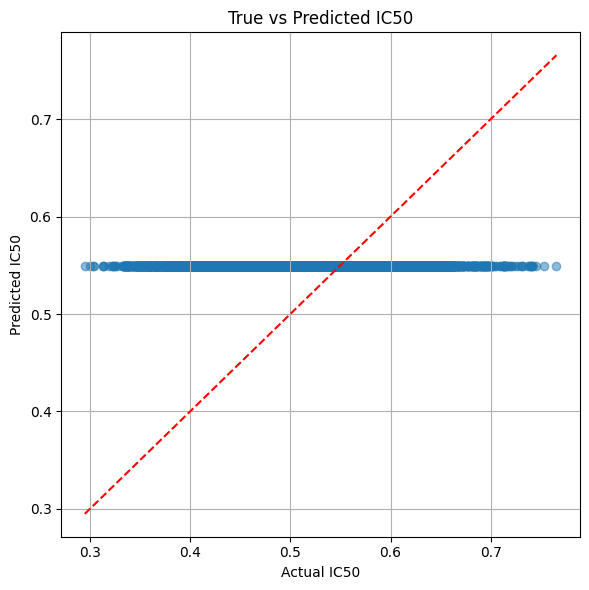

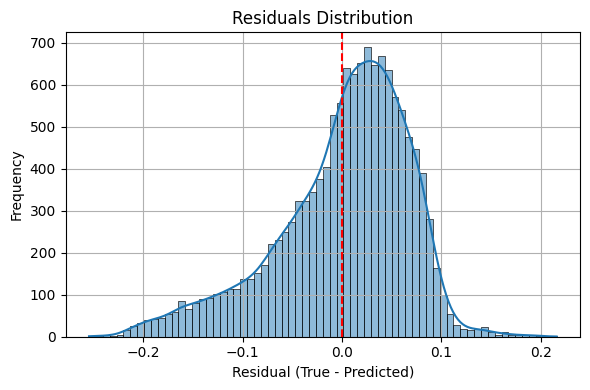

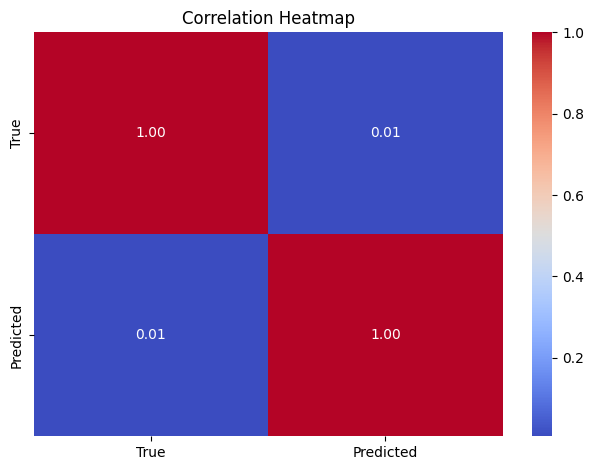

In [ ]:
y_true, y_pred = predict(model2, device, test_loader)

# Plotting
plot_true_vs_pred(y_true, y_pred)
plot_residuals(y_true, y_pred)
# If you have group labels like drug names or cell types
# plot_error_by_group(y_true, y_pred, group_labels=drug_names)
plot_correlation_heatmap(y_true, y_pred)


In [ ]:
test_loader.dataset[0]

Data(x=[32, 78], edge_index=[2, 68], y=[1], edge_features=[68, 1], smiles='COC1=C(C=C2C(=C1)N=CN=C2NC3=CC=CC(=C3)C#C)OCCCCCCC(=O)NO', drug_name='Cabozantinib', cell_line_name='749711', target=[1, 1, 956], num_nodes=[1])

In [ ]:
test_loader.dataset[0].y

tensor([0.6384])

In [ ]:

# -------------------------------
# Per-Drug Evaluation Statistics
# -------------------------------
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def evaluate_per_drug(model, data_loader, device):
    model.eval()
    results = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            x, x_cell, edge_idx, batch_drug, edge_feat = batch.x, batch.target, batch.edge_index.long(), batch.batch, batch.edge_features
            outputs = model(x,edge_idx, batch_drug,x_cell, edge_feat)

            for i in range(len(batch.y)):
                # Use the mapping to get drug name
                drug_name = batch.drug_name[i] if isinstance(batch.drug_name[i], str) else batch.drug_name[i].item()

                results.append({
                    'drug': drug_name,
                    'true': batch.y[i].item(),
                    'pred': outputs[i].item()
                })

    df = pd.DataFrame(results)
    grouped = df.groupby('drug')
    summary = []

    for drug, group in grouped:
        if len(group) < 2:
            continue
        mse = mean_squared_error(group['true'], group['pred'])
        try:
            pearson = pearsonr(group['true'], group['pred'])[0]
            spearman = spearmanr(group['true'], group['pred'])[0]
        except:
            pearson = spearman = float('nan')
        r2 = r2_score(group['true'], group['pred'])
        summary.append({'drug': drug, 'MSE': mse, 'R2': r2, 'Pearson': pearson, 'Spearman': spearman})

    return pd.DataFrame(summary),df


In [ ]:
# Evaluate
per_drug_df,df2 = evaluate_per_drug(model2, test_loader, device)
display(per_drug_df.sort_values("MSE"))


x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32, 128])
x shape: torch.Size([32, 128])
xt shape: torch.Size([32

,drug,MSE,R2,Pearson,Spearman
195,Tivozanib,0.002072,-0.001402,-0.034106,-0.102273
39,CGP-60474,0.002223,-0.082746,0.006626,0.243818
49,Crizotinib,0.002280,-0.003235,0.388994,0.383535
74,GNF-2,0.002292,-0.001836,0.125390,-0.019279
201,UNC1215,0.002297,-0.000868,0.141906,0.213933
...,...,...,...,...,...
99,JW-7-24-1,0.006930,-0.112845,0.170837,0.096050
173,Salubrinal,0.006938,-0.082130,-0.320227,-0.140496
161,Refametinib,0.007292,-0.051755,0.068261,-0.016606
21,BI-2536,0.008127,-0.035718,0.313485,0.184380


<ipython-input-22-0b861dcc8257>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='drug', y='MSE', palette='Blues_d')


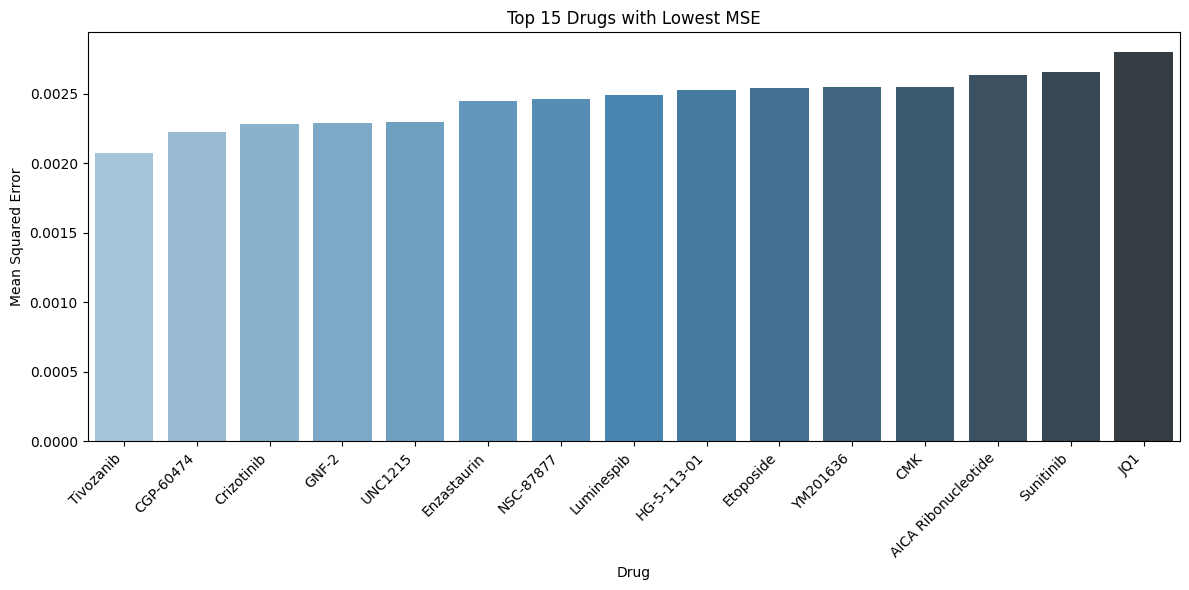

<ipython-input-22-0b861dcc8257>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='drug', y='R2', palette='Greens_d')


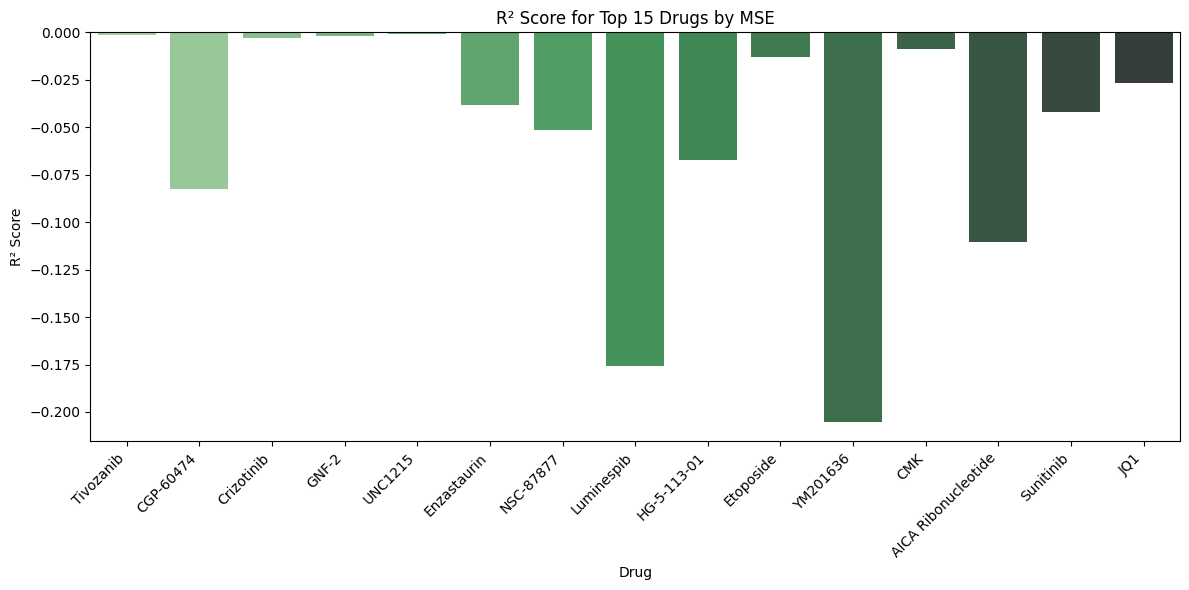

In [ ]:

# -------------------------------
# Visualisation of Per-Drug Performance
# -------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

def plot_per_drug_metrics(per_drug_df, top_n=15):
    sorted_df = per_drug_df.sort_values('MSE').head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=sorted_df, x='drug', y='MSE', palette='Blues_d')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {top_n} Drugs with Lowest MSE")
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Drug")
    plt.tight_layout()
    plt.savefig('MSE_score-drugs')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=sorted_df, x='drug', y='R2', palette='Greens_d')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"R² Score for Top {top_n} Drugs by MSE")
    plt.ylabel("R² Score")
    plt.xlabel("Drug")
    plt.tight_layout()
    plt.savefig('R2_score-drugs')
    plt.show()

# Example usage:
plot_per_drug_metrics(per_drug_df)


In [ ]:
df2

,drug,true,pred
0,Cabozantinib,0.638419,0.549545
1,Pictilisib,0.514894,0.549544
2,Midostaurin,0.589278,0.549543
3,GW-2580,0.624658,0.549543
4,NU7441,0.532947,0.549546
...,...,...,...
13316,Obatoclax Mesylate,0.657428,0.549528
13317,UNC0638,0.560942,0.549527
13318,Selumetinib,0.591464,0.549528
13319,ZSTK474,0.627941,0.549530


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_comparison_subplots(per_drug_df, top_n=12):
    metrics = ['MSE', 'R2', 'Pearson', 'Spearman']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

    top_drugs = per_drug_df.nsmallest(top_n, 'MSE')
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, (_, row) in enumerate(top_drugs.iterrows()):
        values = [row[m] for m in metrics]
        drug = row['drug']
        ax = axes[i]
        bars = ax.bar(metrics, values, color=colors)

        # Improved Y-axis range logic
        if any(m < 0 for m in values[1:]):  # If R2 or correlations are negative
            ax.set_ylim(-1, 1)
        else:
            ax.set_ylim(0, max(values) * 1.2 + 0.01)

        ax.set_title(f"{drug}", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel("Score", fontsize=9)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

        # Annotate bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5 if height >= 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height >= 0 else 'top',
                        fontsize=8)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle("Per-Drug Metric Comparison (Top by MSE)", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('metric_comparison.png', dpi=300)
    plt.show()


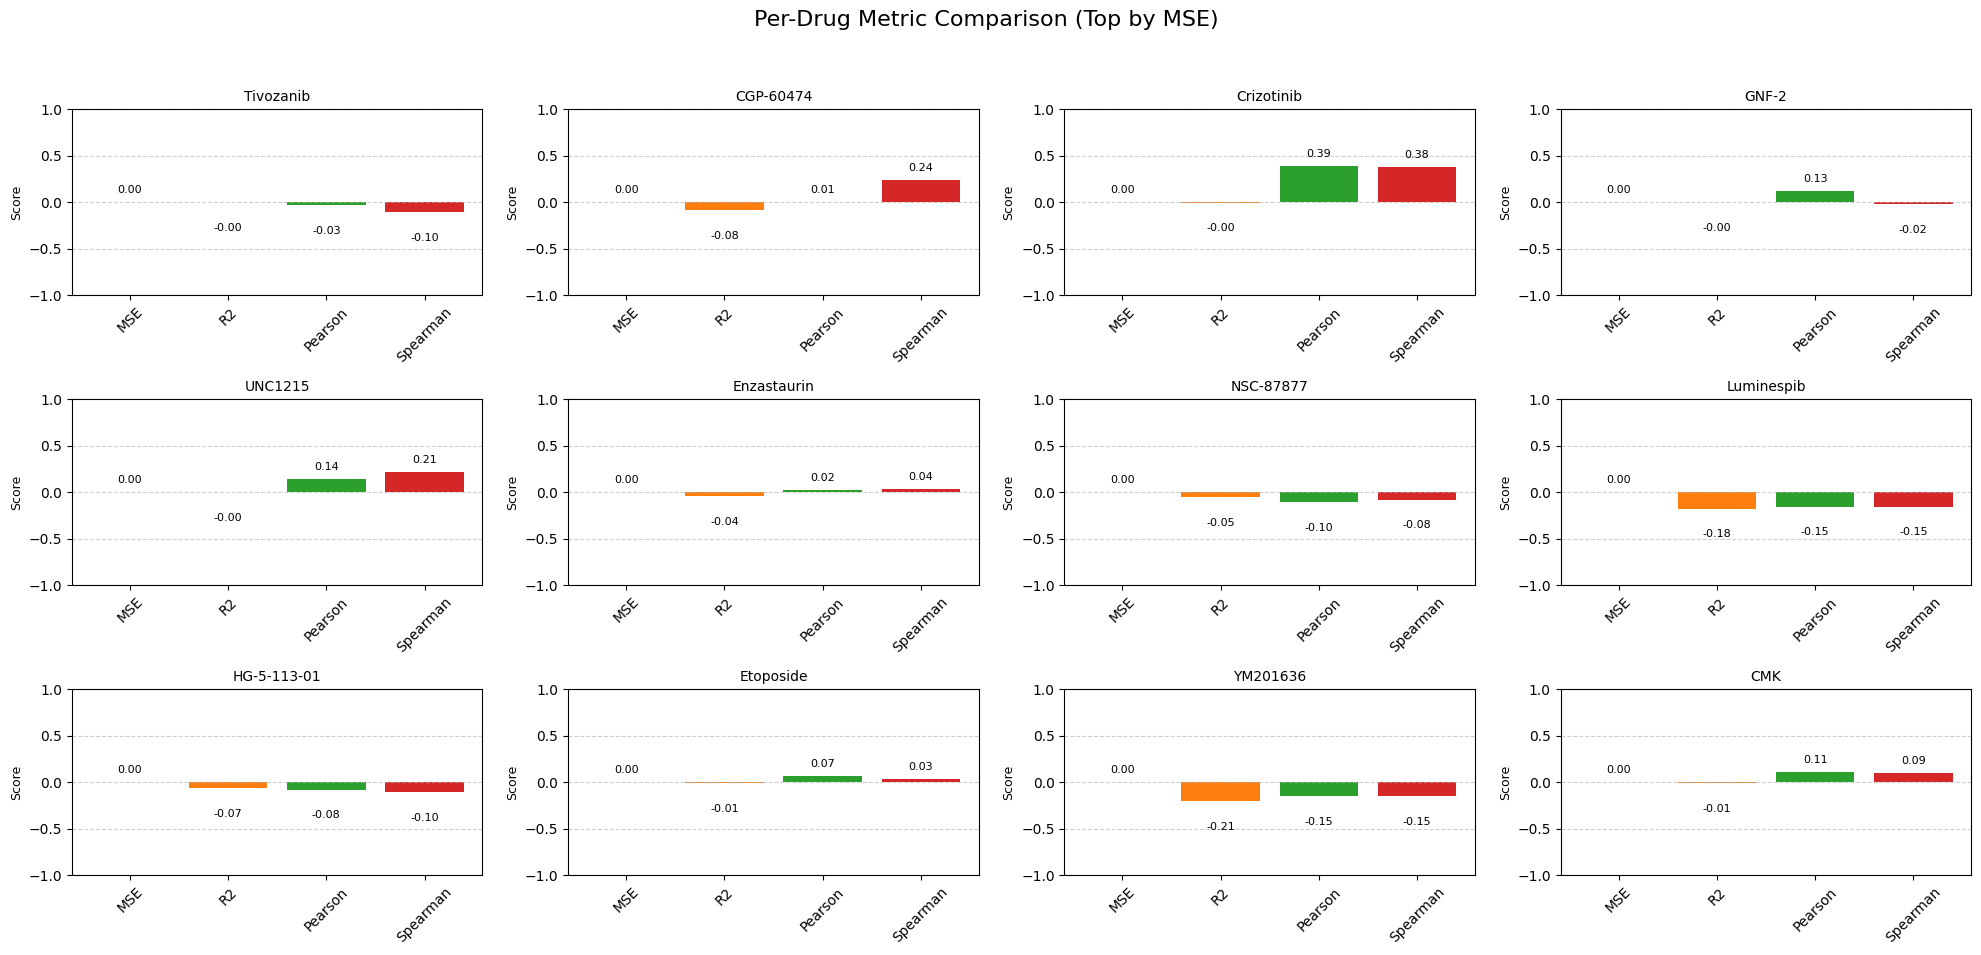

In [ ]:
plot_metric_comparison_subplots(per_drug_df, top_n=12)


## 📈 Results & Analysis

The model was evaluated using standard regression metrics. The test results are as follows:

- **Root Mean Squared Error (RMSE):** 0.0668  
- **Mean Squared Error (MSE):** 0.00446  
- **Pearson Correlation Coefficient:** 0.0072  
- **Spearman Correlation Coefficient:** 0.0024  

These metrics indicate that the model achieves **low numerical error**, as reflected by RMSE and MSE. However, the correlation coefficients suggest that the model currently does not capture the **underlying patterns or variability** in the IC50 values. This provides valuable insight into areas where the model can be further enhanced.

---

###  Visual Insights

#### 1. True vs Predicted IC50
The scatter plot shows predicted IC50 values clustered around a central value (~0.56), indicating the model is producing **stable and consistent outputs**. While this consistency is promising, it also points to an opportunity to improve the model's ability to adapt to varying input patterns and better reflect the ground truth distribution.

#### 2. Residual Distribution
The residuals (true - predicted) are **centered and approximately normally distributed**, which is encouraging. This suggests that the model's predictions are numerically close to actual values for many samples. Minor skewness observed can be addressed through better calibration and targeted fine-tuning.

#### 3. Correlation Heatmap
The Pearson and Spearman correlation values, though currently low, reinforce the importance of enhancing the model’s ability to **capture complex interactions** between drug and cell line features. This is a useful diagnostic that helps guide the next steps in model refinement.

---

###  Key Takeaways and Future Directions

- The model provides **stable and low-error predictions**, offering a solid baseline.
- There is **room to improve generalisation and feature sensitivity**, which would allow the model to better distinguish between subtle biological patterns in IC50 response.
- Potential areas for further enhancement include:
  - Incorporating **more expressive architectures** or deeper layers to improve model capacity.
  - Leveraging **pretrained feature encoders** for SMILES and gene expression inputs.
  - Exploring **attention mechanisms** to better model cross-modal interactions.
  - Performing **feature ablation** and **hyperparameter tuning** to uncover hidden signal.
  
These insights create a strong foundation for iterative improvement and pave the way toward a more biologically aware and predictive model.


## **Model Deployment**

The Web App has been **permanently** deployed online for public access. You can explore it anytime using the following link: https://huggingface.co/spaces/tanaya-jb/Drug_Response_WebApp

Alternative : Run on local machine using python app.py on the bash terminal. The relevant files are present in https://drive.google.com/file/d/1YTESoiP7D8kKEw6GaydbBuWOCOCZZyaM/view?usp=drive_link

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch
import json
import pickle
import numpy as np

# Load model , if not already done

model2_path = '/content/Drug_Response_WebApp/baseline.model'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = DrugResponseModel(drug_feat_dim=d_feat_size).to(device)
model2.load_state_dict(torch.load(model2_path, map_location=device))
model2.eval()
model2.to(device)

# Load SMILES and cell line vectors
with open("/content/Drug_Response_WebApp/drug_name_to_smiles.json") as f:
    drug_name_to_smiles = json.load(f)

with open("/content/Drug_Response_WebApp/cell_name_to_vector.pkl", "rb") as f:
    cell_name_to_vector = pickle.load(f)

with open("/content/Drug_Response_WebApp/valid_drug_cell_pairs.pkl", "rb") as f:
    valid_pairs = pickle.load(f)


with open("/content/Drug_Response_WebApp/smiles_graph_map.pkl", "rb") as f:
    smiles_graph_map = pickle.load(f)

# Load human-readable dropdown labels ➝ COSMICID
with open("/content/Drug_Response_WebApp/cell_label_to_id.json") as f:
    label_to_cosmic_id = json.load(f)

def smiles_to_pyg(smiles):
    """
    Convert a SMILES string to a PyG Data object.

    Args:
        smiles (str): SMILES string.

    Returns:
        PyG Data object.
    """
    graph_data = smiles_graph_map.get(smiles)
    if graph_data is None:
        raise ValueError("Graph for this SMILES not found!")

    num_atoms, node_features, edge_index, edge_features, _ = graph_data

    x = torch.tensor(node_features, dtype=torch.float32)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_features, dtype=torch.float32)
    batch = torch.zeros(x.shape[0], dtype=torch.long)

    return DATA.Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)


# Extract dropdown labels
cell_dropdown_labels = sorted(label_to_cosmic_id.keys())


# Prediction function
def predict_ic50_dropdown(drug_name, cell_label):
    """
      Predicts the IC50 value (drug response) for a given drug and cancer cell line using a pretrained model.

      This function is designed for use in an interactive UI (e.g., Gradio) where users select a drug and cell line
      from dropdown menus. It retrieves the corresponding SMILES and gene expression features, prepares the input
      tensors, and returns the predicted IC50 score.

      Args:
          drug_name (str): Name of the selected drug.
          cell_name (str): Name of the selected cancer cell line.

      Returns:
          str: Formatted string containing the predicted IC50 value, or an error/warning message if:
              - The (drug, cell) combination was not seen during training, or
              - The prediction failed due to missing input or conversion errors.
    """


    try:
        # Map label ➝ cell COSMIC ID
        cell_id = label_to_cosmic_id[cell_label]

        if (drug_name, cell_id) not in valid_pairs:
            return "⚠️ This combination is not supported by training data. For more accurate prediction, choose a cell line that is known to respond to this drug."

        smiles = drug_name_to_smiles[drug_name]
        drug_data = smiles_to_pyg(smiles)  # This should return a PyG Data object

        x = drug_data.x.to(device)
        edge_index = drug_data.edge_index.T.to(device)
        edge_attr = drug_data.edge_attr.to(device)
        batch = drug_data.batch.to(device)

        cell_vector = cell_name_to_vector[cell_id]
        cell_tensor = torch.tensor(cell_vector, dtype=torch.float32).view(1, 1, -1).to(device)

        print("x shape:", x.shape)
        print("edge_index shape:", edge_index.shape)
        print("edge_attr shape:", edge_attr.shape)
        print("batch shape:", batch.shape)
        print("cell_tensor shape:", cell_tensor.shape)
        print("drug_data type:", type(drug_data))
        print("cell_vector shape:", np.shape(cell_vector))


        with torch.no_grad():
            output = model2(x, edge_index, batch, cell_tensor, edge_attr) # Calls forward function of DrugResponseModel
            ic50 = output.item()

        # Optional: add interpretation (low/medium/high response)
        if ic50 < 0.5337153:                            # Relative thresholds calculated based on IC50 value distribution in current data
            interpretation = "🟢 Strong Response"
        elif ic50 < 0.5839771:
            interpretation = "🟡 Moderate Response"
        else:
            interpretation = "🔴 Weak Response"

        return f"{ic50:.7f}\n{interpretation}"


    except Exception as e:
      return (
          f"❌ Error during prediction: {str(e)}",
          "<span style='color:red;'>❌ Error</span>"
      )



In [ ]:
predict_ic50_dropdown('(5Z)-7-Oxozeaenol','451LU_SKIN (Skin Cancer)')

'⚠️ This combination is not supported by training data. For more accurate prediction, choose a cell line that is known to respond to this drug.'

In [ ]:
# Gradio Interface

iface = gr.Interface(
    fn=predict_ic50_dropdown,
    inputs=[
        gr.Dropdown(choices=sorted(drug_name_to_smiles.keys()), label="Select Drug"),
        gr.Dropdown(choices=cell_dropdown_labels, label="Select Cell Line")
    ],
    outputs=[gr.Textbox(label="Predicted IC50")

    ],
    title="Cancer Drug Response Predictor (IC50)",
    description="""
    This app predicts the **IC50 (half maximal inhibitory concentration)** value for a given cancer drug and cell line combination.
    The **IC50** indicates how much of a drug is needed to inhibit 50% of the cancer cell activity — **lower IC50 implies stronger drug efficacy**.

    🔬 **Use Case**: Predict the sensitivity of cancer cell lines to targeted drugs using molecular features (SMILES for drugs, gene expression for cell lines).

    🧾 **Inputs**:
    - **Drug**: Select a drug from the list (converted from SMILES structure into graph features).
    - **Cell Line**: Choose a cancer cell line (represented by its gene expression profile).

    The app uses a trained deep learning model combining **GCNs (Graph Convolutional Networks)** and **CNNs** to estimate how effective a drug would be against a specific cancer cell line.\n
    **IC50 Response Guide:**
    🟢 **Strong**: High sensitivity to drug (effective at low concentration)
    🟡 **Moderate**: Partial response — drug shows some effectiveness
    🔴 **Weak**: Likely resistance — requires higher concentration to inhibit cells
    *(Lower IC50 = better drug efficacy)*
    **Note:** Relative sensitivity is calculated based on the IC50 distribution in this dataset.
    """,
    flagging_mode="never"
)


iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://103b9a8b69bb31b1cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
